In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as spopt
import scipy.integrate as spint
import scipy.interpolate as spinterp

## Ep. 10:

*Approach:* Create three functions to fit, and find fit parameters with 1-$\sigma$ errors. Plot the various models along with the residuals, and find goodness-of-fit to determine which model is best.

In [2]:
data = pd.read_csv('pulsar-timing.txt', delim_whitespace=True, engine='python',
                        header=0, index_col=False)
dates = np.linspace(1974.93, 1981.14, 1000)

In the following figures, I show each individual model plotted against the data. I also run a $\chi_2$ test on the models. The null hypothesis for all tests is that the model fits the data. I recquire a goodness-of-fit (p-value) > 0.05 to accept the hypothesis.

In [3]:
def fit_nth_order(dates, dts, errs, order):
    '''Perform wieghted least squares fit of supplied data, fitting a polynomial of 0th, 1st or 2nd order.
    Also prints the MLE of the parameters along with their 1-sigma error. Lastly performs chi^2 test of data
    and plots results.'''
    # define fit functions according to order
    if order == 0:
        fit_func = lambda x, a: a
    elif order == 1:
        fit_func = lambda x, a, b: a + b*x
    elif order == 2:
        fit_func = lambda x, a, b, c: a + b*x + c*x**2
    # perform fit and calculate errors
    ml_cfpars, ml_cfcovar = spopt.curve_fit(fit_func, dates, dts, sigma=errs)
    err = np.sqrt(np.diag(ml_cfcovar)) 
    print('Fit parameters and 1-sig error:', ml_cfpars, '+/-', err)
    
    # perform chi^2 test
    minchisq = np.sum(((dts-fit_func(dates, *ml_cfpars))/errs)**2)
    dof = len(dates)-len(ml_cfpars)
    print("Minimum Chi-squared = "+str(minchisq)+" for "+str(dof)+" d.o.f.")
    print("The goodness-of-fit is: ",sps.chi2.sf(minchisq,df=dof))
    
    # plot data and fit along with residuals
    date_space = np.linspace(1974.93, 1981.14, 1000)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    # Plot data as points with y-errors
    ax1.errorbar(dates, dts, yerr=errs, marker="o", linestyle="")
    # Plot the model as a continuous curve
    if order == 0:
        ax1.hlines(ml_cfpars[0], date_space[0], date_space[-1], color='Red', lw=2)
    else:
        ax1.plot(date_space, fit_func(date_space, *ml_cfpars), color='Red', lw=2)
    ax1.set_ylabel("dt", fontsize=14)
    ax1.set_title(f'{order}-order weighted least squares fit', fontsize=14)
    ax1.tick_params(labelsize=14)
    # Plot the data-model residuals as points with errors:
    ax2.errorbar(dates, dts-fit_func(dates, *ml_cfpars),
                 yerr=errs, marker="o", linestyle="")
    ax2.set_xlabel("Year",fontsize=14)
    ax2.set_ylabel("Residuals", fontsize=14)
    ax2.axhline(0.0, color='r', linestyle='dotted', lw=2) ## when showing residuals it is useful to also show the 0 line
    ax2.tick_params(labelsize=12)
    plt.show()

Fit parameters and 1-sig error: [-1.08392562] +/- [0.15098539]
Minimum Chi-squared = 3548.1567279428273 for 12 d.o.f.
The goodness-of-fit is:  0.0


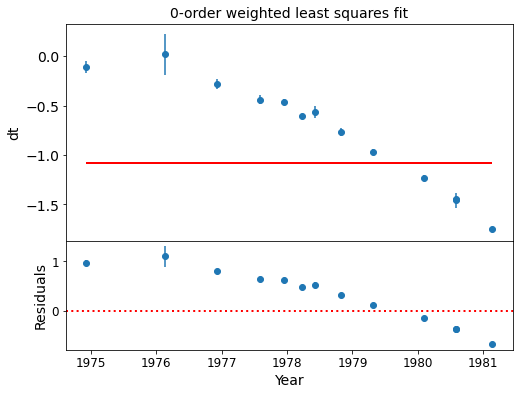

In [4]:
fit_nth_order(data.date, data.dt, data.error, 0)

Here, the null hypothesis is rejected at the 95% confidence level.

Fit parameters and 1-sig error: [ 6.80635748e+02 -3.44393183e-01] +/- [4.64600881e+01 2.34708395e-02]
Minimum Chi-squared = 172.46601027189018 for 11 d.o.f.
The goodness-of-fit is:  3.665613336266108e-31


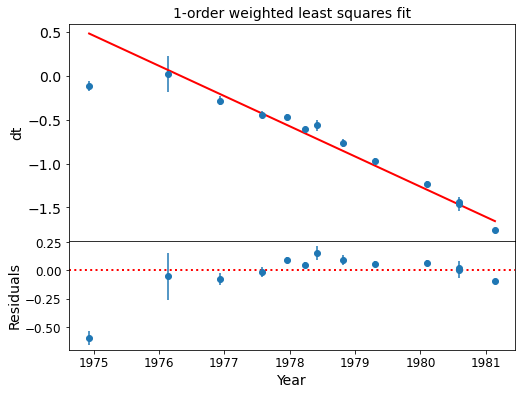

In [5]:
fit_nth_order(data.date, data.dt, data.error, 1)

Here, the null hypothesis cannot be rejected at the 95% confidence level, as the p-value is much lower than the recquired threshold value.

Fit parameters and 1-sig error: [-1.61323313e+05  1.63378539e+02 -4.13650132e-02] +/- [1.30972875e+04 1.32362888e+01 3.34418997e-03]
Minimum Chi-squared = 10.50664560648874 for 10 d.o.f.
The goodness-of-fit is:  0.3972219687734592


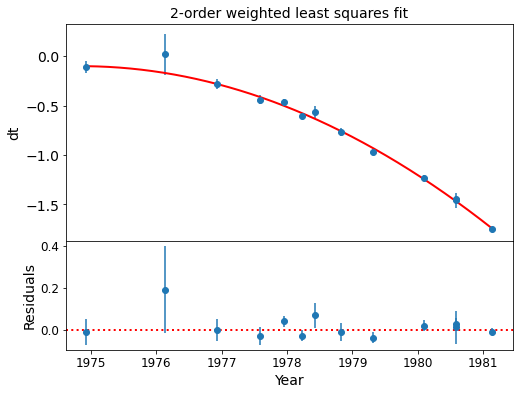

In [6]:
fit_nth_order(data.date, data.dt, data.error, 2)

Here, the null hypothesis is rejected at the 95% confidence level.

*Conclusion:* Even though the quadratic fit looks to be more accurate, the linear fit gives the best goodness-of-fit. This might be cause by the model being over-fitted. The $\chi^2$ value is of the order of magnitude of the d.o.f., while in the linear model this is not the case.

## Ep. 11:

*Approach:* Load in data, and rebin as in the episode to have a minimum number of counts per bin in the histogram. Subsequently, make an a-b grid with 100x100 items, each a possible combination of parameters for the power law. Calculate the $\chi^2$ value at each a-b combination, to find best fit, as well as 1, 2 and 3 sigma levels. As a model, I have to use the integrated power law model, to take into account any possible underlying effects in each bin of the histogram. These can then be plotted in a contour plot as in the episode. Then, I'll do something similar, but for the data before it has been rebinned. Also, instead of calculating the $\chi^2$ value for each point in the grid, I calculate the Poisson LogLikelihood. With the resulting LogLikelihod grid I can plot the contours, just as done with the $\chi^2$.

In [7]:
photens = np.genfromtxt('photon_energies.txt')

def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

def grid2d_chisqmin(ab_index, ab_range, ab_steps, parm, model, xval, yval, dy):
    '''Finds best fit and then carries out chisq minimisation for a 2D grid of fixed parameters.'''
    a_grid = np.linspace(ab_range[0][0],ab_range[0][1],ab_steps[0])
    b_grid = np.linspace(ab_range[1][0],ab_range[1][1],ab_steps[1])
    chisq_grid = np.zeros((len(a_grid),len(b_grid)))
    # First obtain best-fitting values for a and b and corresponding chi-squared
    ml_cfpars, ml_cfcovar = spopt.curve_fit(model, xval, yval, parm, sigma=dy)
    minchisq = np.sum(((yval-model(xval,*ml_cfpars))/dy)**2)
    ab_best = [ml_cfpars[ab_index[0]], ml_cfpars[ab_index[1]]]
    free_parm = parm
    # Now fit for each a and b in the grid, to do so we must use a lambda function to insert the fixed 
    # a and b into the model function when it is called by curve_fit, so that curve_fit does not use 
    # a or b as one of the free parameters so they remain at the fixed grid value in the fit.
    for i, a_val in enumerate(a_grid):
        for j, b_val in enumerate(b_grid):
            fnctn = lambda xval, *free_parm: model(xval, *np.insert(np.insert(free_parm,ab_index[0],a_val),
                                                                    ab_index[1],b_val))
            chisq_grid[i,j] = np.sum(((yval-model(xval,
                        *np.insert(np.insert(ml_cfpars,ab_index[0],a_val),ab_index[1],b_val)))/dy)**2)
                
    return ab_best, minchisq, a_grid, b_grid, chisq_grid

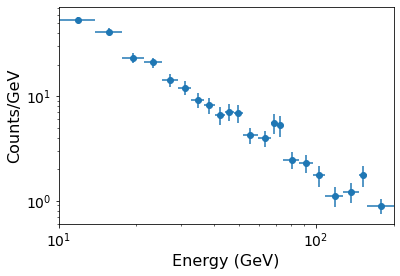

In [8]:
# Now we make our unbinned histogram.  We can keep the initial number of bins relatively large.
emin, emax = 10., 200.   # We should always use the known values that the data are sampled over 
                         # for the range used for the bins!
nbins = 50
counts, edges = np.histogram(photens, bins=nbins, range=[emin,emax], density=False)

# And now we use our new function to rebin so there are at least mincounts counts per bin:
mincounts = 20  # Here we set it to our minimum requirement of 20, but in principle you could set it higher
counts_rebin, edges_rebin = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges_rebin) # calculates the width of each bin
cdens = counts_rebin/bwidths # determines the count densities
cdens_err = np.sqrt(counts_rebin)/bwidths # calculate the errors: remember the error is based on the counts, 
# not the count density, so we have to also apply the same normalisation.
energies = (edges_rebin[:-1]+edges_rebin[1:])/2.  # This calculates the energy bin centres
# Now plot the data - use a log-log scale since we are plotting a power-law
plt.figure()
plt.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
plt.xlabel("Energy (GeV)", fontsize=16)
plt.ylabel("Counts/GeV", fontsize=16)
plt.tick_params(labelsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10.0,200.0)
plt.show()

Here we see the rebinned data. We notice that the count density follows a power law as a function of energy.

In [9]:
# create power law model y = ax^b
def pl_model(x, *parm):
    '''Simple power-law function.'''
    pl_norm = parm[0]  # here the function given means that the normalisation corresponds to that at a value 1.0
    pl_index = parm[1]
    return pl_norm * x**pl_index

def model_int_cf(ebins, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ebins - energy bin edges.
           parm - the curve_fit input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ebins)-1)
    model = pl_model
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

In [10]:
def plot_contours_chi2(ab_index, ab_range, ab_steps, parm, model, xval, yval, dy):
    '''Plots contours of 1-, 2- and 3-sigma regions of the MLE of the model provided, using chi2.'''
    ab_best, minchisq, a_grid, b_grid, chisq_grid = grid2d_chisqmin(ab_index,ab_range,ab_steps,
                                    parm,model,xval,yval,dy)
    # Determine the chisq_2 values which contain 1, 2 and 3-sigma regions:
    del1 = sps.chi2.isf(2*sps.norm.sf(1),df=2)
    del2 = sps.chi2.isf(2*sps.norm.sf(2),df=2)
    del3 = sps.chi2.isf(2*sps.norm.sf(3),df=2)
    print('Best fit parameters [a,b]:', ab_best)
    print("1, 2, 3-sigma contours correspond to delta-chisq =",del1,del2,del3)

    # Now plot the contours, including a cross to mark the location of the MLEs
    # First we assign all three variables to their own 2D arrays:
    X, Y = np.meshgrid(a_grid,b_grid,indexing='ij')
    Z = chisq_grid
    levels = [minchisq+del1, minchisq+del2, minchisq+del3] # plots the 1, 2 and 3-sigma
    # confidence contours
    plt.figure()
    plt.contour(X, Y, Z, levels, colors=('r', 'g', 'b'))
    plt.scatter(*ab_best, marker="+")
    plt.xlabel(r'$a$', fontsize=14)
    plt.ylabel(r'$b$', fontsize=14)
    plt.title('$\chi^2$ grid')
    plt.show()

Best fit parameters [a,b]: [2695.8605004131714, -1.5725093885531372]
1, 2, 3-sigma contours correspond to delta-chisq = 2.295748928898636 6.180074306244174 11.82915808190081


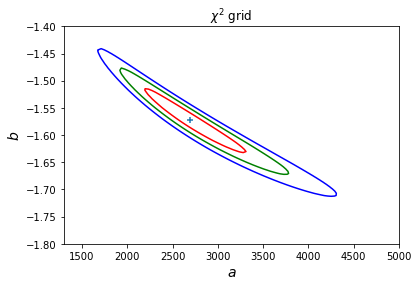

In [11]:
# run for integrated power-law model in specified range
model = model_int_cf
parm = [2500., -1.5] # starting parameters for initial fit
par_indices = [0, 1]
par_ranges = [[1300, 5000],[-1.4, -1.8]]
par_steps = [100,100]

plot_contours_chi2(par_indices,par_ranges,par_steps,parm,model,edges_rebin,cdens,cdens_err)

In this plot we see the 1, 2 and 3 $\sigma$ regions of the $\chi^2$ performed on a grid of possible power law coefficients $a$ and $b$. The cross marks the point with the minimum $\chi^2$ value.

Now we use a similar approach to calculate the Poisson LogLikelihood minimum and grid. Instead of calculating the $\chi^2$ for every value combination in the grid, we calculate the Poisson LogLikelihood using the LogLikelihood_Pois_Integ function.

In [12]:
def grid2d_ll(result,ab_range,ab_steps,parm,model,xval,yval,dy):
    '''Finds best fit and then carries out Poisson LogLikelihood minimization for a 2D grid of fixed parameters.'''
    a_grid = np.linspace(ab_range[0][0],ab_range[0][1],ab_steps[0])
    b_grid = np.linspace(ab_range[1][0],ab_range[1][1],ab_steps[1])
    ll_grid = np.zeros((len(a_grid),len(b_grid)))
    # First obtain best-fitting values for a and b and corresponding chi-squared
    ab_best = [result.x[0], result.x[1]]
    min_ll = result.fun
    # Now fit for each a and b in the grid.
    for i, a_val in enumerate(a_grid):
        for j, b_val in enumerate(b_grid):
            ll_grid[i,j] = LogLikelihood_Pois_Integ([a_val,b_val], pl_model, edges, counts)
    return ab_best, min_ll, a_grid, b_grid, ll_grid 

In [13]:
def plot_contours_ll(result,ab_range,ab_steps,parm,model,xval,yval,dy):
    '''Plots contours of 1-, 2- and 3-sigma regions of the MLE of the model provided, using Poisson LogLikelihood.'''
    ab_best, min_ll, a_grid, b_grid, ll_grid = grid2d_ll(result,ab_range,ab_steps,parm,model,xval,yval,dy)
    # Determine the chisq_2 values which contain 1, 2 and 3-sigma regions:
    del1 = 0.5*sps.chi2.isf(2*sps.norm.sf(1),df=2)
    del2 = 0.5*sps.chi2.isf(2*sps.norm.sf(2),df=2)
    del3 = 0.5*sps.chi2.isf(2*sps.norm.sf(3),df=2)

    print('Best fit parameters [a,b]:', ab_best)
    print("1, 2, 3-sigma contours correspond to delta-chisq =",del1,del2,del3)

    # Now plot the contours, including a cross to mark the location of the MLEs
    # First we assign all three variables to their own 2D arrays:
    X, Y = np.meshgrid(a_grid,b_grid,indexing='ij')
    Z = ll_grid
    levels = [min_ll+del1, min_ll+del2, min_ll+del3] # plots the 1, 2 and 3-sigma
    # confidence contours
    plt.figure()
    plt.contour(X, Y, Z, levels, colors=('r', 'g', 'b'))
    plt.scatter(*ab_best, marker="+")
    plt.xlabel(r'$a$', fontsize=14)
    plt.ylabel(r'$b$', fontsize=14)
    plt.title('Poisson LogLikelihood grid')
    plt.show()

Covariance matrix: [[0.00167929 0.00033136]
 [0.00033136 0.00011048]]
Normalisation at 1 GeV = 2555.19507633651 +/- 0.04097911375985234
Power-law index = -1.5509355551083115 +/- 0.010511031769118955
Minimum log-likelihood = 126.29341311424108
Best fit parameters [a,b]: [2555.19507633651, -1.5509355551083115]
1, 2, 3-sigma contours correspond to delta-chisq = 1.147874464449318 3.090037153122087 5.914579040950405


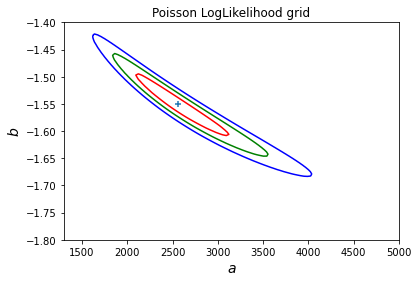

In [14]:
def LogLikelihood_Pois_Integ(parm, model, ebins, counts): 
    '''Calculate the negative Poisson log-likelihood for a model integrated over bins. 
       Inputs:
           parm - model parameter list.
           model - model function name.
           ebins, counts - energy bin edges and corresponding counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    i = 0
    ymod = np.zeros(len(counts))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm),ebins[i],ebins[i+1])
        # we don't normalise by bin width since the rate parameter is set by the model and needs to be 
        # in counts per bin
        i=i+1        
    pd = sps.poisson(ymod) #we define our Poisson distribution
    return -sum(pd.logpmf(counts))

# redefine search parameters (result is expected to be similar to that using chi2)
parm = [2500.0, -1.5]
par_rangesb = [[1300, 5000],[-1.4, -1.8]]
par_stepsb = [100, 100]

bin_widthsb = np.diff(edges) # calculates the width of each bin
counts_errb = np.sqrt(counts)/bin_widthsb
energiesb = (edges[:-1]+edges[1:])/2

# to find minimum of function
result = spopt.minimize(LogLikelihood_Pois_Integ, parm, args=(pl_model, edges, counts), method='BFGS')

err = np.sqrt(np.diag(result.hess_inv))
print("Covariance matrix:",result.hess_inv)
print("Normalisation at 1 GeV = " + str(result.x[0]) + " +/- " + str(err[0]))
print("Power-law index = " + str(result.x[1]) + " +/- " + str(err[1]))
print("Minimum log-likelihood = " + str(result.fun))

plot_contours_ll(result,par_rangesb,par_stepsb,parm,pl_model,energies,counts,counts_errb)

*Conclusion:* Both approaches give similar results. The Poissong LogLikelihood gives results that are slightly closer to 0. Nevertheless the shapes of the 1, 2 and 3 $\sigma$ regions resemble one another closely. The Poissong LogLikelihood increases faster as you get farther away from the minimum than the $\chi^2$ does, and so its regions are slightly smaller, but with similar shape.

## Ep. 12:

In [15]:
def model_int_cf2(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ecent - energy bin centres, dummy array with length len(ebins)-1 to fool curve_fit into 
                   accepting the function as the correct format for curve_fit.
           ebins - energy bin edges.
           model, parm - the curve_fit model name and input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, *parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

def plot_spec_model(ebins,cdens,cdens_err,cdens_model):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    energies = (ebins[1:]+ebins[:-1])/2
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='o')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(energies, cdens/cdens_model, xerr=bwidths/2., yerr=cdens_err/cdens_model, fmt='o')
    ax2.set_xlabel("Energy (GeV)", fontsize=16)
    ax1.set_ylabel("Counts/Gev", fontsize=14)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(ebins[0],ebins[-1]) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    # at the boundaries.
    plt.show()

#### a)
*Approach:* Do as in the episode. Read in the energies from the file, rebin it so that we have a minimum number of counts per bin. Afterwards, we convert from counts to count density, by dividing out the bin-width. We can also get the error ont he density by taking the square root, and also normalizing wising the bin-widths. After that, we need to fit the appropriate cutoff power law to the data. To do this, we create a cutoff_pl function defined as in the instructions. Subsequently, we fit using weighted least squares with scipy.optimize.curve_fit. The results can then be plotted using the plot_spec_model provided

In [16]:
def cutoff_pl(E_arr, *parm):
    '''Cut-off power law model'''
    N_0   = parm[0]
    Gamma = parm[1]
    E_cut = parm[2]
    N_cont = N_0*E_arr**(-Gamma)*np.exp(-E_arr/E_cut)
    return N_cont

N_0   = 40508.013676670635 +/- 4567.822284320631
Gamma = 1.2479732116084248 +/- 0.03604799474608982
E_cut = 113.87488219184293 +/- 6.310758591692902
Minimum Chi-squared = 65.18823864397615 for 51 d.o.f.
The goodness of fit is: 0.08739174468790753


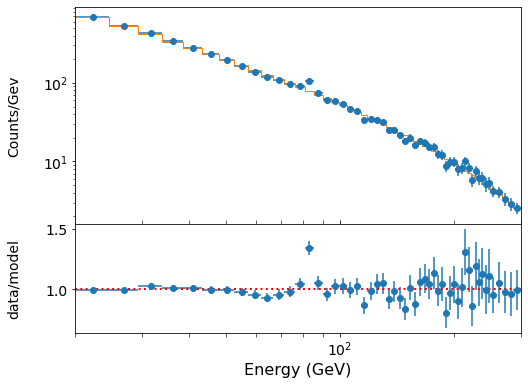

In [17]:
#  First read in the data.
photens = np.genfromtxt('event_energies.txt')

# Now we make our unbinned histogram.
emin, emax = 20., 300.   # Use known limits

nbins = 60
counts, edges = np.histogram(photens, bins=nbins, range=[emin,emax], density=False)

# Rebin to have at least mincounts counts per bin:
mincounts = 20
counts2, edges2 = histrebin(mincounts, counts, edges)

bwidths = np.diff(edges2) # calculates the width of each bin
cdens = counts2/bwidths # determines the count densities
cdens_err = np.sqrt(counts2)/bwidths # calculate the errors: remember the error is based on the counts, 
# not the count density, so we have to also apply the same normalisation.
energies = (edges2[:-1]+edges2[1:])/2.  # This calculates the energy bin centres

model = cutoff_pl
p0 = [40000., 1.2, 120.]  # Initial cutoff power-law parameters
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf2(energies, edges2, model, *parm),
                                        energies, cdens, p0, sigma=cdens_err)
# Print results obtained from fit
err = np.sqrt(np.diag(ml_cfcovar))
# print("Covariance matrix:",ml_cfcovar)

print("N_0   = " + str(ml_cfpars[0]) + " +/- " + str(err[0]))
print("Gamma = " + str(ml_cfpars[1]) + " +/- " + str(err[1]))
print("E_cut = " + str(ml_cfpars[2]) + " +/- " + str(err[2]))
minchisq = np.sum(((cdens - model_int_cf2(energies, edges2, model, *ml_cfpars))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq) + " for " + str(len(cdens)-len(p0)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq,df=(len(cdens)-len(p0)))))

# Return the model y-values for model with parameters equal to the MLEs
best_model = model_int_cf2(energies, edges2, model, *ml_cfpars)
# Now plot the data and model and residuals
plot_spec_model(edges2, cdens, cdens_err, best_model)

*Conclusions:* Fromt the data/model ratio, we can observe that around the 80-85GeV mark there could be a gaussian feature, as expected. 

#### b)
*Approach:* I'll create a function which consists of the power law continuum with a gaussian function of fixed sigma (inherent to the detector). Then, I'll fit this function over the data as done in part a. Since there are more parameters to fit, in order to give scipy a little help, I can set strict bounds for the power law parameters, as these should be similar to the ones obtained above. To check for the significance of the change, I apply Wilks' theorem, with the Bonferroni correction to take into account that I did not already know the line's expected energy range.

In [18]:
def gaussian_cutoff_pl(E_arr, *parm):
    '''Cut-off power law model with an additional gaussian peak'''
    N_0    = parm[0]
    Gamma  = parm[1]
    E_cut  = parm[2]
    N_tot  = parm[3]
    E_cent = parm[4]
    
    sigma  = 1.3 # sigma fixed for the detector
    N_gauss = N_tot/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(E_arr-E_cent)**2/(sigma)**2)
    N_cont = N_0*E_arr**(-Gamma)*np.exp(-E_arr/E_cut)

    return N_cont + N_gauss

N_0    = 44646.836757577315 +/- 3583.047519225974
Gamma  = 1.280029422276778 +/- 0.025707521967608938
E_cut  = 118.49794564963132 +/- 4.825397998738089
N_tot  = 155.83676023284775 +/- 24.453147349662995
E_cent = 82.05813685395707 +/- 0.5385001335339276
Minimum Chi-squared = 30.265647267853176 for 49 d.o.f.
The goodness of fit is: 0.9837378006238704


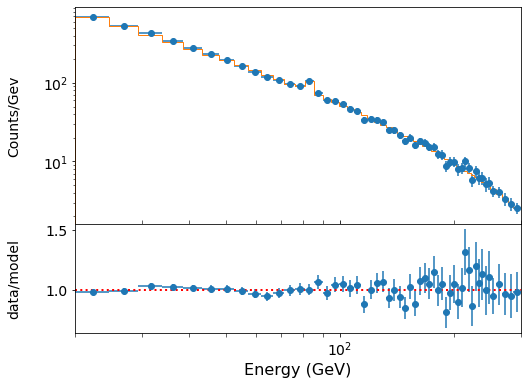

In [19]:
model2 = gaussian_cutoff_pl
p02 = [40700., 1.249, 114., 150., 81.]  # Initial cutoff power-law parameters
bounds2 = [[40690., 1.245, 113., 0., 75.],[45000., 1.3, 150., 300., 87.]] # bounds for which to fit the function
ml_cfpars2, ml_cfcovar2 = spopt.curve_fit(lambda energies, *parm: model_int_cf2(energies, edges2, model2, *parm),
                                          energies, cdens, p02, bounds=bounds2, sigma=cdens_err)
# Print results obtained from fit
err2 = np.sqrt(np.diag(ml_cfcovar2))

print("N_0    = " + str(ml_cfpars2[0]) + " +/- " + str(err2[0]))
print("Gamma  = " + str(ml_cfpars2[1]) + " +/- " + str(err2[1]))
print("E_cut  = " + str(ml_cfpars2[2]) + " +/- " + str(err2[2]))
print("N_tot  = " + str(ml_cfpars2[3]) + " +/- " + str(err2[3]))
print("E_cent = " + str(ml_cfpars2[4]) + " +/- " + str(err2[4]))

minchisq2 = np.sum(((cdens - model_int_cf2(energies, edges2, model2, *ml_cfpars2))/cdens_err)**2.)

print("Minimum Chi-squared = " + str(minchisq2) + " for " + str(len(cdens)-len(p02)) + " d.o.f.")
print("The goodness of fit is: " + str(sps.chi2.sf(minchisq2,df=(len(cdens)-len(p02)))))

# Return the model y-values for model with parameters equal to the MLEs
best_model2 = model_int_cf2(energies, edges2, model2, *ml_cfpars2)
# Now plot the data and model and residuals
plot_spec_model(edges2, cdens, cdens_err, best_model2)

*Conclusions:* The addition of the gaussian feature significantly improves the fit. Firstly, the minimum $\chi^2$ value is less than half that of the previous one, accompanied by a much lower p-value. In order to test the significance of this improvement, we apply Wilks' theorem.

$\Delta\chi^2=60.7806467770-25.8841793588=34.8964674182$

The number of added parameters is not two, as the line energy is not a nestable model parameter, since the likelyhood does not smoothly change if we change the position of such a sharp feature. Hence we set the d.o.f. to 1. 

In [20]:
print("p-value for our delta-chi-squared: ",sps.chi2.sf(34.8964674182,df=1))

p-value for our delta-chi-squared:  3.4771116549995527e-09


The p-value obtained is extremely significant. But, since we did not expect to find an energy line there before seeing the data, we still have to apply the Bonferroni correction. 

$p(x=0|n=20,\theta=p)=(1-3.4771116549995527*10^{-9})^{20} \approx 1$

Thus we conclude that the emission feature at ~80GeV is very significant, as the chance of seeing it if it were not there is $1-p\approx0$.

#### c)

*Approach:* Create a model that contains the power law background with two gaussian emission features. The position of the second emission, predicted by Prof. Petra Biggs, should be fixed at 144GeV. After this, perform a 1d $\chi^2$ grid minimization of the line flux, to find the upper bound to 3-$\sigma$ level.

In [21]:
def double_gaussian_cutoff_pl(E_arr, *parm):
    '''Cut-off power law model with two additional gaussian peak'''
    parm = parm[0]
    N_0     = parm[0]
    Gamma   = parm[1]
    E_cut   = parm[2]
    N_tot1  = parm[3]
    E_cent1 = parm[4]
    N_tot2  = parm[5]
    E_cent2 = parm[6]
    sigma2  = parm[7]
    
    sigma  = 1.3 # sigma fixed for the detector
    N_gauss1 = N_tot1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(E_arr-E_cent1)**2/(sigma)**2)
    N_gauss2 = N_tot2/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(E_arr-E_cent2)**2/(sigma2)**2)
    N_cont = N_0*E_arr**(-Gamma)*np.exp(-E_arr/E_cut)

    return N_cont + N_gauss1 + N_gauss2

In [22]:
def grid1d_chisqmin_cfint(a_index,a_range,a_steps,parm,model,xval,yval,dy,xedges):
    '''Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed parameters.
       Input: 
            a_index - index of 'a' parameter (in input list parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - parameter list for model to be fitted.
            model - name of model function to be fitted.
            xval, dyval, dy - data x, y and y-error arrays
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid'''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda xval, *parm: model_int_cf2(xval, xedges, 
                            model, parm), xval, yval, parm, sigma=dy)
    
    minchisq = np.sum(((yval-model_int_cf2(xval,xedges,model,*ml_cfpars))/dy)**2)
    a_best = ml_cfpars[a_index]
    # Now remove 'a' from the input parameter list, so this parameter may be frozen at the 
    # grid value for each fit
    free_parm = np.delete(parm,a_index)
    # Now fit for each 'a' in the grid, to do so we must use a lambda function to insert the fixed 
    # 'a' into the model function when it is called by curve_fit, so that curve_fit does not use 
    # 'a' as one of the free parameters so it remains at the fixed grid value in the fit.
    for i, a_val in enumerate(a_grid):        
        ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda xval, *parm: model_int_cf2(xval, xedges, 
                            model, parm), xval, yval, parm, sigma=dy)        
        chisq_grid[i] = np.sum(((yval-model_int_cf2(xval,xedges,model,
                                                   *np.insert(ml_cfpars,a_index,a_val)))/dy)**2)
        print(i+1,'steps: chisq =',chisq_grid[i],'for a =',a_val,' minimum = ',minchisq,' for a =',a_best)
    return a_best, minchisq, a_grid, chisq_grid  

def calc_upper_chisq(delchisq,minchisq,a_grid,chisq_grid):
    '''Function to return upper values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid,a_grid)
    a_upper = chisq_interp_upper(minchisq+delchisq)
    return a_upper

In [23]:
def model_int_cf2(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ecent - energy bin centres, dummy array with length len(ebins)-1 to fool curve_fit into 
                   accepting the function as the correct format for curve_fit.
           ebins - energy bin edges.
           model, parm - the curve_fit model name and input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

In [24]:
# Give the fixed parameters and define a new function to hide them from curve_fit:
fixed_en = 144.
fixed_sig = 1.3
new_model = lambda x, parm: double_gaussian_cutoff_pl(x,np.insert(np.insert(parm,6,fixed_en),7,fixed_sig))
# new_model = lambda x, parm: double_gaussian_cutoff_pl(x,np.insert(parm,6,fixed_en))


# Below is the parameter list which curve_fit will see initially, with PL norm, 
# PL index and Gaussian line normalisation.
parm = [40700., 1.28, 119., 155.77, 82.06, 100., 144.]
# Now we select the parameter to step through and give the range and number of steps:
a_index = 5
par_range = [0,40]
n_steps = 20
# Run the grid calculation
a_best, minchisq, a_grid, chisq_grid = grid1d_chisqmin_cfint(a_index,par_range,n_steps,parm,new_model,
                             energies,cdens,cdens_err,edges2)

# Now give the output
delchisq = 9 #3-sigma corresponds to a delta-chisq of 9
a_upper = calc_upper_chisq(delchisq,minchisq,a_grid,chisq_grid)
print("3-sigma upper limit on line flux: ", a_upper)

C:\Users\sanch\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1 steps: chisq = 30.28424997500646 for a = 0.0  minimum =  29.67682276212948  for a = -8.508041849198445
2 steps: chisq = 30.6220501903417 for a = 2.1052631578947367  minimum =  29.67682276212948  for a = -8.508041849198445
3 steps: chisq = 31.034234120299917 for a = 4.2105263157894735  minimum =  29.67682276212948  for a = -8.508041849198445
4 steps: chisq = 31.520801764881092 for a = 6.315789473684211  minimum =  29.67682276212948  for a = -8.508041849198445
5 steps: chisq = 32.08175312408526 for a = 8.421052631578947  minimum =  29.67682276212948  for a = -8.508041849198445
6 steps: chisq = 32.71708819791238 for a = 10.526315789473683  minimum =  29.67682276212948  for a = -8.508041849198445
7 steps: chisq = 33.426806986362486 for a = 12.631578947368421  minimum =  29.67682276212948  for a = -8.508041849198445
8 steps: chisq = 34.21090948943556 for a = 14.736842105263158  minimum =  29.67682276212948  for a = -8.508041849198445
9 steps: chisq = 35.0693957071316 for a = 16.8421052631

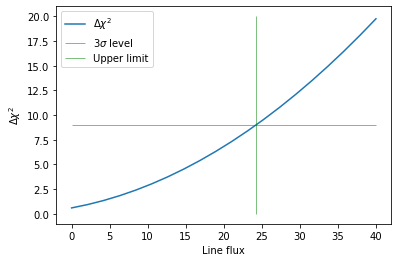

In [25]:
plt.plot(a_grid, chisq_grid-minchisq, label='$\Delta\chi^2$')
plt.ylabel('$\Delta\chi^2$')
plt.xlabel('Line flux')
plt.hlines(9, 0, 40, 'r', linewidth=0.5, label='$3\sigma$ level')
plt.vlines(a_upper, 0, 20, 'g', linewidth=0.5, label='Upper limit')
plt.legend()
plt.show()

*Conclusion:* Here we see that the 3-$\sigma$ upper boundary on the line flux is at 24.22. Also interesting to note, although not tested for, the minimum $\chi^2$ value is located at a negative line flux, which would correspond to an absorption line, instead of an emission line.